# Vehicle Type Prediction Using Simulated Trajectory Data

This is a data-science project that aims to predict if a vehicle is either a car or a bus using machine-learning models and simulated data.

This project is based on data contained in this [repository](https://github.com/pgrandinetti/standard-traffic-data). The authors took work produced by the Communication Systems Department of Sophia-Antipolis, France, that was already open-sourced and made it easily accessible and reproducible, enabling this project to happen. A special thanks goes to them!

## Achieved Results

The best model was able to achieve an F1 Score of **0.873** on data unseen by the training process.

## About the Data

The data is originated from a simulation using the [SUMO](https://www.eclipse.org/sumo/) (Simulation of Urban MObility) software. The scenario is called [MoST](Monaco SUMO Traffic) and consists of a simulation of traffic in the Principality of Monaco, covering around 70 km² of metropolitan area, spanning from 4 AM to 2 PM. It contains traffic data on vehicles, pedestrians, and bicycles, such as speed, place coordinates, slope, orientation angle, vehicle type, etc. This data is aggregated into several time-series sampled at 15-second intervals, forming the main object which we'll manipulate through this project.

Because the generated traffic data is so extensive and large, we'll use only a small subset of it: the simulated traffic between 4 AM and 6:30 AM.

## Requirements and Setup

To replicate this project, you'll need to download the files in this GitHUb repo ***(LINK TO FINAL REPO)*** and run this jupyter notebook ***(LINK TO NOTEBOOK)*** (which contains all the code if you want to check it), but not before installing the required packages (it is recommended to create a new virtual environment in order to avoid dependency conflicts). As I usually develop my projects in both Linux and Windows simultaneously, you can choose which one fits you best. If you are on Linux, open a terminal and type:

	pip install -r linux-requirements.txt

Or if you prefer Windows, use:

	pip install -r windows-requirements.txt

Though we use several python libraries on this project, the main star is the [`sktime`](https://www.sktime.org/en/latest/) package, which is a special machine-learning package utilized to work with time-series data. Its syntax is based on that of the famous `scikit-learn` package, being even compatible with some tools like optimization, model selection, and data handling from the more known library. 


## Initialization

Without further ado, let's start by importing all the libraries we'll need. We'll also create a flag that's used for rendering the plots as static images (our notebook won't be able to show any generated images if we keep the plots as interactive images, the default option for the `plotly` package). If you want to have the plots as interactive images, just change this flag to `False` and you'll be all set. We'll also create a folder that will contain all the images generated, in case we want them for showing on other environments (on our README.md, for example). Of course, this is totally optional; just remember to remove the part of the code that saves the images to this folder.

In [1]:
import pandas as pd
import numpy as np
from sktime.utils.data_processing import from_multi_index_to_nested
from time import time
from itertools import combinations

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import make_scorer

# models
from sklearn.linear_model import LogisticRegression
from sktime.classification.compose import TimeSeriesForestClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.shapelet_based import ROCKETClassifier

# model selection
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import pickle

# plotting
import plotly.express as px

# flag for posting on github: if True, allow plots to be shown on the repository, but loses the interactivity of plots
github = True

# makes folde that contais plots. this can be supressed if wanted
try: 
    os.mkdir('images')
except:
    print("Folder already exists")

Folder already exists


## Data Preprocessing

In these next steps, we will download, select and preprocess our data. In the end, it will save a new file called `cleaned_data.csv`. If you have already gone through this process and the file is already on your directory, you can skip to the ***Data Processing*** section.

Now, let's download the data to our project folder. As stated before, we'll be only using the subset of the entire dataset that corresponds to the traffic generated from 4 AM to 6:30 AM. Make sure you have enough space available (it's around 200 MB in size). If you already have the file, don't worry; it will check if it already exists before downloading it.

In [2]:
!wget -nc https://standard-traffic-data.s3.us-east-2.amazonaws.com/most_0400_0600_1_5.csv

--2021-02-20 20:14:47--  https://standard-traffic-data.s3.us-east-2.amazonaws.com/most_0400_0600_1_5.csv
Resolving standard-traffic-data.s3.us-east-2.amazonaws.com (standard-traffic-data.s3.us-east-2.amazonaws.com)... 52.219.100.136
Connecting to standard-traffic-data.s3.us-east-2.amazonaws.com (standard-traffic-data.s3.us-east-2.amazonaws.com)|52.219.100.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 212534013 (203M) [binary/octet-stream]
Saving to: ‘most_0400_0600_1_5.csv’

most_0400_0600_1_5. 100%[===================>] 202,69M  9,52MB/s    in 23s     

2021-02-20 20:15:11 (8,82 MB/s) - ‘most_0400_0600_1_5.csv’ saved [212534013/212534013]



Then, it's time to load our dataframe into `Pandas`.

In [3]:
data = pd.read_csv('most_0400_0600_1_5.csv', sep=';')

Let's have an overview of our data.

In [4]:
data.head(10)

,timestep_time,vehicle_angle,vehicle_id,vehicle_lane,vehicle_pos,vehicle_slope,vehicle_speed,vehicle_type,vehicle_x,vehicle_y,vehicle_z,person_angle,person_edge,person_id,person_pos,person_slope,person_speed,person_x,person_y,person_z
0,14400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14405.0,80.89,bus_M1:France.0,152927_1,12.10,3.01,0.00,bus,1085.69,197.96,54.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14410.0,71.94,bus_M1:France.0,152927_1,23.63,1.31,3.97,bus,1096.59,201.56,54.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14415.0,57.57,bus_M1:France.0,152927_1,57.99,0.66,8.49,bus,1126.83,217.57,55.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14420.0,32.10,bus_M1:France.0,152927_1,113.32,0.63,12.78,bus,1167.22,253.89,55.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,14425.0,53.85,bus_M1:Eze.0,-153460_1,18.12,1.73,3.09,bus,44.23,1368.97,358.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,14425.0,42.04,bus_M1:France.0,152927_1,176.17,0.97,12.58,bus,1205.74,303.31,56.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,14425.0,204.72,bus_M2:France.0,-153424#0_1,14.37,1.58,1.46,bus,3080.45,2998.66,478.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,14430.0,56.30,bus_M1:Eze.0,-153460_1,36.33,6.28,0.24,bus,59.11,1378.92,357.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,14430.0,34.27,bus_M1:France.0,152927_1,239.87,1.51,12.91,bus,1245.55,352.82,57.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.describe()

,timestep_time,vehicle_angle,vehicle_pos,vehicle_slope,vehicle_speed,vehicle_x,vehicle_y,vehicle_z,person_angle,person_pos,person_slope,person_speed,person_x,person_y,person_z
count,2.067350e+06,1.228876e+06,1.228876e+06,1.228876e+06,1.228876e+06,1.228876e+06,1.228876e+06,1.228876e+06,838473.000000,837976.000000,838473.000000,837977.000000,838473.000000,838473.000000,838473.000000
mean,2.021132e+04,1.702282e+02,1.832031e+02,-6.081239e-01,5.878740e+00,4.394096e+03,2.036820e+03,9.745693e+01,161.218636,181.459266,-0.353450,7.413234,4313.035494,2069.419362,109.380626
std,9.779872e+02,9.915551e+01,5.781648e+02,5.173104e+00,6.913619e+00,1.581162e+03,1.031879e+03,1.157750e+02,100.731614,355.824890,6.752039,6.224017,1748.461993,1075.116513,120.228287
min,1.440000e+04,0.000000e+00,0.000000e+00,-8.873000e+01,0.000000e+00,-2.100000e-01,9.346000e+01,0.000000e+00,0.000000,0.000000,-90.000000,0.000000,-0.210000,93.460000,-0.080000
25%,1.952500e+04,8.179000e+01,1.553000e+01,-2.750000e+00,3.000000e-02,3.935520e+03,1.313255e+03,2.073000e+01,69.470000,13.380000,-2.250000,1.190000,3548.030000,1338.410000,26.250000
50%,2.035500e+04,1.968800e+02,4.360000e+01,0.000000e+00,2.180000e+00,4.513730e+03,1.859050e+03,6.108000e+01,157.550000,51.950000,0.000000,6.900000,4461.740000,1935.200000,67.800000
75%,2.102500e+04,2.323100e+02,1.335425e+02,1.090000e+00,1.233000e+01,5.155550e+03,2.665060e+03,1.069800e+02,240.100000,159.620000,1.530000,12.870000,5136.770000,2852.400000,126.250000
max,2.159500e+04,3.599900e+02,1.323421e+04,9.000000e+01,5.547000e+01,9.976570e+03,6.359290e+03,5.972100e+02,359.990000,4183.480000,90.000000,46.090000,9976.570000,6356.520000,575.200000


Looking at the outputs above, we can have an idea of how the data is organized: each row contains an entry, a reading, of a specific vehicle on a specific time-stamp, showing the feature values that correspond to that vehicle on that time. We'll only keep some of these features; `vehicle_speed` is an obvious one, but we'll assume that maybe cars change less their orientation than busses since the former tends to go from one point to another through the city, while the latter has to change its direction more in order to cover a specific area for picking and dropping people, so we're keeping `vehicle_angle` as well.

So, in the end, we'll maintain `vehicle_id`, `timestep_time` (our instance identifiers), the previously mentioned features, and our target label `vehicle_type`.

In [6]:
# keeps only relevant columns
data = data[['vehicle_id', 'timestep_time', 'vehicle_speed', 'vehicle_angle', 'vehicle_type']]

Our dataframe now looks like this:

In [7]:
data.head(10)

,vehicle_id,timestep_time,vehicle_speed,vehicle_angle,vehicle_type
0,NaN,14400.0,NaN,NaN,NaN
1,bus_M1:France.0,14405.0,0.00,80.89,bus
2,bus_M1:France.0,14410.0,3.97,71.94,bus
3,bus_M1:France.0,14415.0,8.49,57.57,bus
4,bus_M1:France.0,14420.0,12.78,32.10,bus
5,bus_M1:Eze.0,14425.0,3.09,53.85,bus
6,bus_M1:France.0,14425.0,12.58,42.04,bus
7,bus_M2:France.0,14425.0,1.46,204.72,bus
8,bus_M1:Eze.0,14430.0,0.24,56.30,bus
9,bus_M1:France.0,14430.0,12.91,34.27,bus


Now let's see how the vehicle categories are defined.

In [8]:
data['vehicle_type'].unique()

array([nan, 'bus', 'train', 'hw_trailer', 'fastbicycle', 'motorcycle',
       'passenger4', 'passenger2b', 'truck', 'delivery', 'coach',
       'passenger2a', 'passenger3', 'passenger1', 'moped', 'trailer',
       'avgbicycle', 'hw_motorcycle', 'hw_passenger1', 'taxi',
       'emergency', 'slowbicycle', 'authority', 'uber', 'hw_coach',
       'hw_passenger2a', 'hw_truck', 'hw_passenger3', 'hw_passenger4',
       'hw_delivery', 'hw_passenger2b', 'army'], dtype=object)

According to the [documentation](https://sumo.dlr.de/docs/Definition_of_Vehicles,_Vehicle_Types,_and_Routes.html#abstract_vehicle_class), all the vehicle types that start with `passenger` are a subclass of cars. Therefore, we will unify these labels after we drop all categories that are neither cars nor busses.

In [9]:
# drops all entries that are neither cars nor busses
data = data[(data['vehicle_type'] == 'bus') | (data['vehicle_type'].str.startswith('passenger'))]

# unifies car label for all entries
data['vehicle_type'] = data['vehicle_type'].map(lambda x: 'car' if x.startswith('passenger') else x)

Now let's check if there are any null values on our modified dataset.

In [10]:
data.isna().sum()

vehicle_id       0
timestep_time    0
vehicle_speed    0
vehicle_angle    0
vehicle_type     0
dtype: int64

In order to work with the time-series algorithms from the `sktime` package, it is necessary to transform our dataset into a *nested* one. Since we cannot save a nested dataset, we will transform our dataframe into a multi-indexed one and save it to disk. Multi-indexed dataframes can be turned into nested by using the `from_multi_index_to_nested` method from the `sktime` package.

In [11]:
# multindex dataframe
data.sort_values(by=['vehicle_id', 'timestep_time'], inplace=True)
multiindex = pd.MultiIndex.from_frame(data[['vehicle_id', 'timestep_time']])
data.index = multiindex

# drops columns used in indexing
data.drop(['vehicle_id', 'timestep_time'], axis='columns', inplace=True)

Now, let's save our preprocessed dataset.

In [12]:
data.to_csv('cleaned_data.csv')

## Data Processing

Because we can't save a nested dataset, we'll need to load our preprocessed dataset and do the necessary transformations every time we are to interact with our project starting from a fresh boot up. This is the point where, if you have previously run the code before this section, you can run from without the need to repeat the steps before. We'll load the previously saved dataset from disk and print it to see what it looks like.

In [13]:
data = pd.read_csv('cleaned_data.csv', index_col=['vehicle_id', 'timestep_time'])
data.head(10)

vehicle_speed  vehicle_angle vehicle_type
vehicle_id       timestep_time                                           
bus_100:Menton.0 15065.0                 2.59          76.55          bus
                 15070.0                 6.62          64.31          bus
                 15075.0                 7.94          57.08          bus
                 15080.0                 0.00          55.10          bus
                 15085.0                 0.00          55.10          bus
                 15090.0                 0.00          55.10          bus
                 15095.0                 0.00          55.10          bus
                 15100.0                 0.00          55.10          bus
                 15105.0                 0.00          55.10          bus
                 15110.0                 1.06          53.57          bus

In order to work with the time-series algorithms from the `sktime` package, it is necessary to transform our dataset into a *nested* one; a dataset in which each row contains an instance (vehicle ID), each column contains a feature and each cell is an entire time-series. To do this, we will first index our dataframe by both `vehicle_id` and `timestep_time`, making it a muti-indexed dataframe. Then, the function [`from_multi_index_to_nested`](https://www.sktime.org/en/latest/examples/loading_data.html#Using-multi-indexed-pandas-DataFrames) will transform our structure into a nested frame. Because the function resets the index in the transformed dataframe, we need to save our desired index (the column `vehicle_id` reduced to unique values) and reassign it to our frame after we call the function.

In [14]:
# transforms dataframe into a nested sctructure of time-series
index = data.index.get_level_values('vehicle_id').unique()
data = from_multi_index_to_nested(data, instance_index='vehicle_id')
data.index = index

# after the transformation we have a series in each entry containing the repeated values for vehicle type, 
# this makes the feature a single value column again
data['vehicle_type'] = data['vehicle_type'].map(lambda vehicle_type_series: vehicle_type_series.iloc[0])

data.head(10)

,vehicle_speed,vehicle_angle,vehicle_type
vehicle_id,,,
bus_100:Menton.0,15065.0 2.59 15070.0 6.62 15075.0 ...,15065.0 76.55 15070.0 64.31 15075.0 5...,bus
bus_100:Menton.1,15965.0 2.61 15970.0 6.81 15975.0 ...,15965.0 77.50 15970.0 64.96 15975.0 5...,bus
bus_100:Menton.2,16865.0 2.81 16870.0 6.99 16875.0 ...,16865.0 76.85 16870.0 63.03 16875.0 5...,bus
bus_100:Menton.3,17765.0 2.86 17770.0 7.74 17775.0 ...,17765.0 76.54 17770.0 61.21 17775.0 5...,bus
bus_100:Menton.4,18665.0 2.66 18670.0 7.67 18675.0 ...,18665.0 77.08 18670.0 62.67 18675.0 5...,bus
bus_100:Menton.5,19575.0 1.78 19580.0 7.06 19585.0 ...,19575.0 78.81 19580.0 67.61 19585.0 ...,bus
bus_100:Menton.6,20500.0 0.99 20505.0 5.53 20510.0 9.4...,20500.0 80.18 20505.0 67.75 20510.0 5...,bus
bus_100:Menton.7,21365.0 0.68 21370.0 5.21 21375.0 ...,21365.0 80.40 21370.0 67.75 21375.0 ...,bus
bus_100:Nice.0,15125.0 0.00 15130.0 5.38 15135.0 1...,15125.0 231.22 15130.0 235.63 15135.0 ...,bus


We'll now create some new features based on the speed and orientation of vehicles. `speed_variation` and `angle_variation` will be time-series describing how speed and orientation, respectively, change in time. `mean_vehicle_speed` and `std_vehicle_speed` will be both single-dimension features derived from the original `vehicle_speed`, and `mean_speed_variation` and `mean_angle_variation` will also be one-dimensional values computed from the newly created `speed_variation` and `angle_variation`. We'll see how these features help us to predict our target variable. Then, we'll use the `sample` method to randomize the order of our dataframe by making the argument `frac=1`, specifying the sampling to keep the entire dataset. 

In [15]:
# speed mean and standard deviation
data['mean_vehicle_speed'] = data['vehicle_speed'].map(lambda speed: speed.mean())
data['std_vehicle_speed'] = data['vehicle_speed'].map(lambda speed: speed.std())

# speed and angle variation
data['speed_variation'] = data['vehicle_speed'].map(lambda speed: speed.diff())
data['angle_variation'] = data['vehicle_angle'].map(lambda angle: angle.diff())

# speed and angle variation mean
data['mean_speed_variation'] = data['speed_variation'].map(lambda speed_variation: speed_variation.abs().mean())
data['mean_angle_variation'] = data['angle_variation'].map(lambda angle_variation: angle_variation.abs().mean())

# randomize dataframe
data = data.sample(frac=1, random_state=1)

Next, we need to clear some null values generated by the differentiating of speed and orientation; we'll drop the first value of all time-series in the dataset. After that, in order to work with the algorithms in the `sktime` library, all of our time-series need to have the same length for a given feature. We will sample a random interval of each time-series (with all entries having the same choice of time-stamps for all features), but not before removing any samples that have fewer elements than the determined interval size. To keep the procedure reproducible, we'll set a new random seed every time we chop a time-series in the dataset.

In [16]:
# drops 1st element because of generated na values
features = ['vehicle_speed', 'speed_variation', 'angle_variation']
data[features] = data[features].applymap(lambda series: series.iloc[1:])

print(f'Original number of samples:{data.shape[0]}')

chunk_size = 50
data = data[data['vehicle_speed'].map(lambda vehicle_speed: vehicle_speed.size >= chunk_size)]

print(f'Number of samples after size filtering: {data.shape[0]}')

np.random.seed(1)
def get_interval(row):
    '''
    function that randomly chooses a chunk of size *chunk_size* of each series on the dataset 
    '''
    if row.iloc[0].size == chunk_size:
        return row
    else:
        i = np.random.random_integers(low=0, high=(row.iloc[0].size - chunk_size))
        np.random.seed(i)   # sets seed so random generation keeps going in a reproducible way
        return row.map(lambda series: series.iloc[i:i+chunk_size])
        

# chopping the time series in order to normalize their size across the dataset
data[features] = data[features].apply(get_interval, axis=1)

Original number of samples:3118
Number of samples after size filtering: 2857


As we can see above, after nesting the dataframe, it contains 3118 samples; each is a vehicle containing both scalar and time-series features. After we removed the vehicles that had fewer than 50 time-observations, we ended up with 2857 samples, losing 261 in the process.

Let us now see how our targe labels are distributed:

In [17]:
data['vehicle_type'].value_counts()

car    2669
bus     188
Name: vehicle_type, dtype: int64

We can see that our dataset is clearly unbalanced.

Now it's time to split our data into a training and a test dataset. For that, we'll use a common choice for train/test splits that reserves 20% of samples to the test set.

In [18]:
training, test = train_test_split(data, test_size=0.2, random_state=1, stratify=data['vehicle_type'])

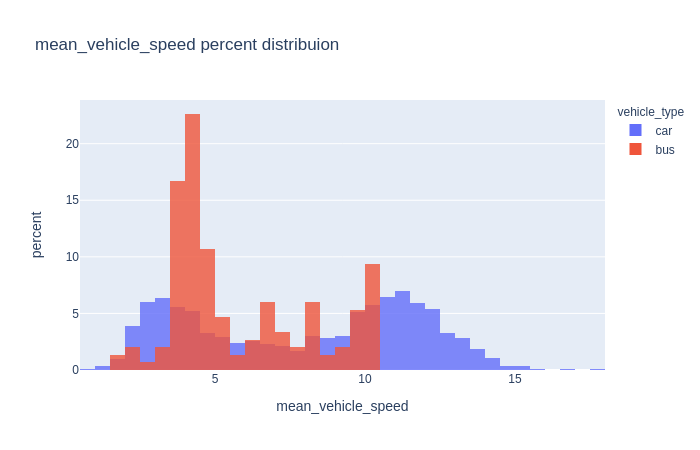

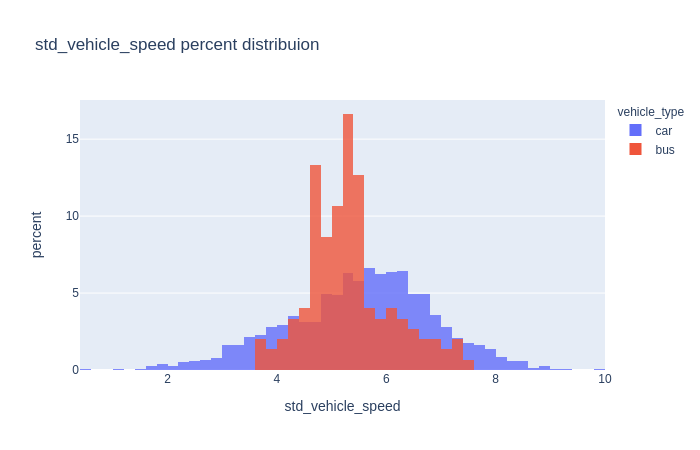

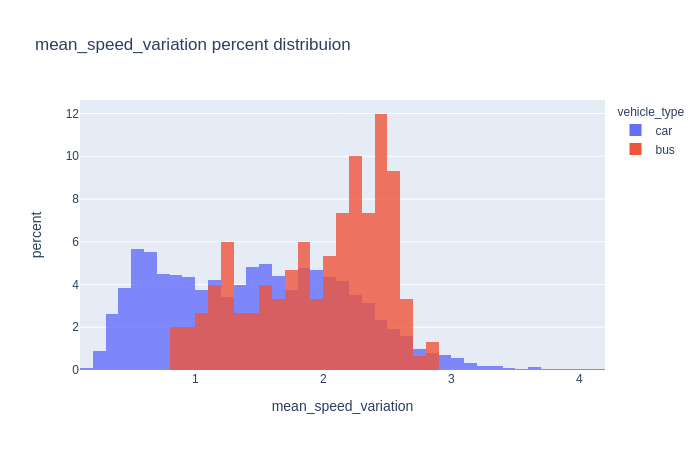

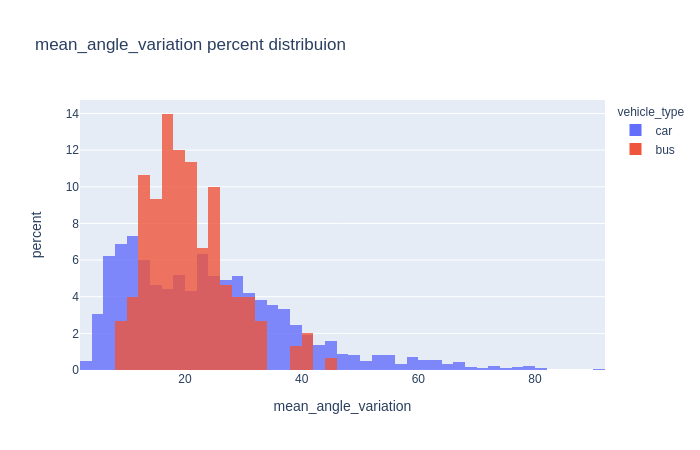

In [19]:
for feature in ['mean_vehicle_speed', 'std_vehicle_speed', 'mean_speed_variation', 'mean_angle_variation']:

    fig = px.histogram(training, x=feature, 
                        histnorm='percent', color='vehicle_type', opacity=0.8, barmode='overlay',
                        title=feature + ' percent distribuion', height=500, width=700)
    if github:
        fig.show('png')

    else:
        fig.show()

    # salves image on image folder. can be supressed if desired
    fig.write_image(os.path.join('images', fig.layout['title']['text'] + '.png'))

 Based on the plots above, it seems like looking only at the data in a tabular manner (that is, not considering the *time* aspect) is not a good way to properly distinguish busses from cars. However, we'll fit a logistic classifier as a baseline classifier for our problem since it is a very simple out-of-the-box tool used for classification and it's recommended for problems with low dimensional-feature-spaces. In order to do that, we'll need to apply different weights for both classes because our dataset is heavily unbalanced (there are a lot more cars than busses).

Since accuracy is not a good measure of performance for models trained on unbalanced datasets, the [F1 Score](https://en.wikipedia.org/wiki/F-score) will be used to evaluate our models; using the F1 Score is a good way of measuring performance on classification tasks that have very unbalanced classes, since it considers both [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall) from the point of view of the minority class, in our case, `bus`. To fit our models and compute the F1 score, we will use the `cross_val_predict` function from `sklearn`. This function uses cross-validation during training and assigns each sample to a test set exactly once; after training, it returns the prediction for every example on the dataset when the said example was on the test set. Also, we'll use a custom function called `compute_results` that will compute the F1 Score and prints it, as well as the Precision and Recall scores and the [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

It is important to note that our Logistic Regressor has the privilege of using the entire data; it will be trained on features that are statistics obtained from the time-series before we sampled shorter time windows from each series, as opposed to our specific time-series models that will train using only those windows.

In [20]:
def compute_results(y_true, y_pred, _time):

    precision = precision_score(y_true, y_pred, pos_label='bus')
    recall = recall_score(y_true, y_pred, pos_label='bus')
    _f1_score = f1_score(y_true, y_pred, pos_label='bus')

    print(f'Training time: {_time:.2f} seconds')
    print('\n')

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {_f1_score}')
    print('\n')

    print('Confusion Matrix:')
    print(confusion_matrix(y_true, y_pred))

In [21]:
from sklearn.model_selection import cross_val_predict

lr = LogisticRegression(random_state=1, class_weight='balanced', n_jobs=-1)

start = time()
lr_results = cross_val_predict(lr, X=training[['mean_vehicle_speed',
                                        'std_vehicle_speed', 
                                        'mean_speed_variation', 
                                        'mean_angle_variation']],
                                        y=training['vehicle_type'], cv=5)
end = time()

compute_results(training['vehicle_type'], lr_results, end-start)

Training time: 3.13 seconds


Precision: 0.3022598870056497
Recall: 0.7133333333333334
F1 Score: 0.42460317460317465


Confusion Matrix:
[[ 107   43]
 [ 247 1888]]


## Time Series Classification Algorithms

The results above suggest that using regular machine learning algorithms for classification with time-series yields poor outcomes. Our experiment gave us a fair recall score, although the precision is low, and thus our F1 score is just over 0.4. Now it's time to test some time-series-specific algorithms. We will test 3 different algorithms, each falling into a specific category of time-series classification models: Composition, Distance-Based, and Shapelet-Based. A brief explanation of those classes of algorithms can be checked in [this article](https://towardsdatascience.com/a-brief-introduction-to-time-series-classification-algorithms-7b4284d31b97).

### Time Series Forest Classifier

The first algorithm we'll try is somewhat similar to what we did with logistic regression: the `TimeSeriesForestClassifier` extracts features (like mean and standard deviation) from intervals of all time-series and then simply applies a traditional random forest classifier on those features. `sktime`'s implementation of this algorithm only works for univariate problems (problems with only one feature). To go around this, we'll have to train a model for each time feature separately. As this method doesn't deal with the time aspect of the data, it makes sense to expect humble results from this option.

In [22]:
# composition
features = ['vehicle_speed', 'speed_variation', 'angle_variation']

for feature in features:

    tsfc = TimeSeriesForestClassifier(random_state=1, n_jobs=-1)

    start = time()
    tsfc_results = cross_val_predict(tsfc, X=training[[feature]], y=training['vehicle_type'], cv=5)
    end = time()

    print(f'Results for Time Series Forest Classifier trained on {feature}:')
    compute_results(training['vehicle_type'], tsfc_results, end-start)
    print('\n')

Results for Time Series Forest Classifier trained on vehicle_speed:
Training time: 59.63 seconds


Precision: 0.8829787234042553
Recall: 0.5533333333333333
F1 Score: 0.680327868852459


Confusion Matrix:
[[  83   67]
 [  11 2124]]


Results for Time Series Forest Classifier trained on speed_variation:
Training time: 58.70 seconds


Precision: 1.0
Recall: 0.2866666666666667
F1 Score: 0.4455958549222798


Confusion Matrix:
[[  43  107]
 [   0 2135]]


Results for Time Series Forest Classifier trained on angle_variation:
Training time: 59.46 seconds


Precision: 0.8333333333333334
Recall: 0.03333333333333333
F1 Score: 0.06410256410256411


Confusion Matrix:
[[   5  145]
 [   1 2134]]




### K-Neighbors Time Series Classifier

The `KNeighborsTimeSeriesClassifier` is a distance-based method for classifying time-series; it is very similar to the classical K-Neighbors Classifier used for normal data, with the distinction that it uses [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping) (DTW) as a measure of the distance between two time-series. As it estimates the distance between each pair of time-series in the dataset, this is a fairly expensive (in terms of computer power) algorithm.

In [23]:
# distance-based
features = ['vehicle_speed', 'speed_variation', 'angle_variation']

knc = KNeighborsTimeSeriesClassifier(n_jobs=-1)

start = time()
knc_results = cross_val_predict(knc, X=training[features], y=training['vehicle_type'], cv=5)
end = time()

compute_results(training['vehicle_type'], knc_results, end-start)

Training time: 47.83 seconds


Precision: 0.17218543046357615
Recall: 0.17333333333333334
F1 Score: 0.17275747508305647


Confusion Matrix:
[[  26  124]
 [ 125 2010]]


### ROCKET Classifier


The [ROCKET Classifier](https://pub.towardsai.net/rocket-fast-and-accurate-time-series-classification-f54923ad0ac9) (RandOM Convolutional KErnal Transform) is a shapelet-based classifier for time-series problems; this means it tries to extract intervals from the time-series that help to discriminate which labels they belong to. The ROCKET algorithm uses convolutional kernels (similar to those used on convolutional neural networks) that transform the shapelets into new features and then apply those features to a linear classifier. This classification solution has proven to be extremely versatile, outperforming more complex algorithms like neural networks.

In [24]:
rck = ROCKETClassifier(random_state=1)

start = time()
rck_results = cross_val_predict(rck, X=training[features], y=training['vehicle_type'], cv=5)
end  = time()

compute_results(training['vehicle_type'], rck_results, end-start)


Training time: 20.03 seconds


Precision: 0.9915254237288136
Recall: 0.78
F1 Score: 0.873134328358209


Confusion Matrix:
[[ 117   33]
 [   1 2134]]


Bellow is a table summarizing our results:

| Results                 |
|-------------------------|
| **Model**                               |**F1 Score**|
| Logistic Regression                     | 0.425 |
| Time Series Forest on `vehicle_speed`   | 0.680 |
| Time Series Forest on `speed_variation` | 0.446 |
| Time Series Forest on `angle_variation` | 0.064 |
| K-Neighbors Time Series                 | 0.173 |
| ROCKET                                  | 0.873 |

As the results above can show us, the ROCKET classifier outperformed the other algorithms for our task. We will now fine-tune and it to see if we can improve it.

### Feature Selection and Fine-Tunning the Best Model

We trained our model assuming all the selected features were relevant to our classification task of telling apart busses from cars; however, this may not hold, so the next step is to try our algorithm with different specific sets of features, starting with one feature at a time.

In [25]:
for feature in features:

    rck = ROCKETClassifier(random_state=1)

    start = time()
    rck_results = cross_val_predict(rck, X=training[[feature]], y=training['vehicle_type'], cv=5)
    end  = time()

    print(f'Results for ROCKET Classifier trained on {feature}:')
    compute_results(training['vehicle_type'], rck_results, end-start)
    print('\n')

Results for ROCKET Classifier trained on vehicle_speed:
Training time: 14.18 seconds


Precision: 0.9918032786885246
Recall: 0.8066666666666666
F1 Score: 0.8897058823529411


Confusion Matrix:
[[ 121   29]
 [   1 2134]]


Results for ROCKET Classifier trained on speed_variation:
Training time: 14.29 seconds


Precision: 0.991869918699187
Recall: 0.8133333333333334
F1 Score: 0.8937728937728938


Confusion Matrix:
[[ 122   28]
 [   1 2134]]


Results for ROCKET Classifier trained on angle_variation:
Training time: 14.28 seconds


Precision: 0.864406779661017
Recall: 0.34
F1 Score: 0.48803827751196177


Confusion Matrix:
[[  51   99]
 [   8 2127]]




The results for each feature can be seen bellow:

| ROCKET F1 Score for Each Feature |
| -------------------------------- |
| **Feature**                      | **F1 Score** |
| `vehicle_speed`                  | 0.890 |
| `speed_variation`                | 0.894 |
| `angle_variation`                | 0.488 |

Interestingly enough, both `vehicle_speed` and `speed_variation`, when used to train the model alone, have slightly improved the score of our classifier while `angle_variation` performed inadequately. One possible move now could be to train our model on `vehicle_speed` and `speed_variation` concurrently. However, since we have a small number of features, we can have the luxury of training on every combination of pairs and see the results.

In [26]:
# creates a list containg all 3 combinations of pairs features
feature_pairs = list(combinations(features, 2))
feature_pairs = [list(pair) for pair in feature_pairs]

for pair in feature_pairs:

    rck = ROCKETClassifier(random_state=1)

    start = time()
    rck_results = cross_val_predict(rck, X=training[pair], y=training['vehicle_type'], cv=5)
    end  = time()

    print(f'Results for ROCKET Classifier trained on {pair[0]} and {pair[1]}:')
    compute_results(training['vehicle_type'], rck_results, end-start)
    print('\n')

Results for ROCKET Classifier trained on vehicle_speed and speed_variation:
Training time: 17.85 seconds


Precision: 0.9921259842519685
Recall: 0.84
F1 Score: 0.9097472924187726


Confusion Matrix:
[[ 126   24]
 [   1 2134]]


Results for ROCKET Classifier trained on vehicle_speed and angle_variation:
Training time: 18.89 seconds


Precision: 0.9829059829059829
Recall: 0.7666666666666667
F1 Score: 0.8614232209737828


Confusion Matrix:
[[ 115   35]
 [   2 2133]]


Results for ROCKET Classifier trained on speed_variation and angle_variation:
Training time: 17.98 seconds


Precision: 0.9914529914529915
Recall: 0.7733333333333333
F1 Score: 0.8689138576779025


Confusion Matrix:
[[ 116   34]
 [   1 2134]]




The results for each pair of features are:

| ROCKET F1 Score for Each Pair of Features   |
| ------------------------------------------- |
| **Features**                                    | **F1 Score** |
| `vehicle_speed` and `speed_variation`           | 0.910 |
| `vehicle_speed` and `angle_variation`           | 0.861 |
| `speed_variation` and `angle_variation`         | 0.869 |

The table above shows us that the combination of `vehicle_speed`and `speed_variation` gave the (slightly) better results; thus, we will keep them as our predictive features for our problem. Now it's time to try to improve our model even further by fine tunning it. For that goal, we will use `sklearns`'s functions [`RandomizedSearchCV`](https://sklearn.org/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) for a wide training hyper-parameter search and [`GridSearchCV`](https://sklearn.org/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) for a narrow specific search. The `RandomizedSearchCV` function samples randomly from a given distribution of training hyper-parameters possibilities in order to give a "general direction" in the search for the best optimization. After that, the `GridSearchCV` looks tries every combination from the set of hyper-parameters given; this set is built around the best results obtained from `RandomizedSearchCV`. Because training an ensemble of models can take too long, we're only going to try different values for the `num_kernels` parameter that, as the name suggests, represents the number of kernels the model uses to transform the data. The default value is 10000, and we'll use a set of all steps of 100 between 1000 and 100000 for our search to randomly sample from.

We'll also need to wrap our F1 Score function using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer) because we need to specify to `f1_score` the minority class, in our case, `bus`.

It's also worth noting that the next step may take a while because we're training our model several times.

In [27]:
features = ['vehicle_speed', 'speed_variation']

rck = ROCKETClassifier(random_state=1)

param_grid = {
    'num_kernels': [n for n in range(100, 100000, 100)],
    'ensemble': [False]
}

start = time()
# wraps f1_score with minority class around make_scorer
scorer  = make_scorer(f1_score, pos_label='bus')
random_search = RandomizedSearchCV(rck, param_grid, n_iter=32, scoring=scorer, cv=5, verbose=1, random_state=1)
random_search.fit(training[features], training['vehicle_type'])
end = time()

print(f'Training time: {(end - start):.2f} seconds')
print('\n')
print("Best hyperparameters found in wide radomized search:")
print(random_search.best_params_)
print('\n')
print('Best F1 Score:')
print(random_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Training time: 2204.24 seconds


Best hyperparameters found in wide radomized search:
{'num_kernels': 92900, 'ensemble': False}


Best F1 Score:
0.9264127300472378


Our random search returned that the best number of kernels found was **92900**, resulting in an average cross-validation score of **0.926**. Now, we will try a more refined search, looking into all 100 intervals between 92000 and 93000 and see what we get.

In [28]:
features = ['vehicle_speed', 'speed_variation']

rck = ROCKETClassifier(random_state=1)

param_grid = {
    'num_kernels': [n for n in range(92000, 93000, 100)],
    'ensemble': [False]
}

start = time()
# wraps f1_score with minority class around make_scorer
scorer  = make_scorer(f1_score, pos_label='bus')
grid_search = GridSearchCV(rck, param_grid, scoring=scorer, cv=5, verbose=1)
grid_search.fit(training[features], training['vehicle_type'])
end = time()

print(f'Training time: {(end - start):.2f} seconds')
print('\n')
print("Best hyperparameters found in narrow grid search:")
print(grid_search.best_params_)
print('\n')
print('Best F1 Score:')
print(grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training time: 1336.15 seconds


Best hyperparameters found in narrow grid search:
{'ensemble': False, 'num_kernels': 92900}


Best F1 Score:
0.9264127300472378


Looks like our narrow search returned the same results found on our wide search: that **92900** is the optimal number of kernels to our model, achieving an F1 Score of **0.926**. Hence, we'll keep this configuration and save our model using [`pickle`](https://docs.python.org/3/library/pickle.html).

In [29]:
final_model = grid_search.best_estimator_

filename = 'best_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(final_model, file)

### Scoring the Final Model on Unseen Data

Finally, it is time to score our model using our test dataset, which we separated from training at the beginning of our work so our model could be validated on unseen data. We'll load the model and then score it.

In [30]:
filename = 'best_model.pkl'
with open(filename, 'rb') as file:
    final_model = pickle.load(file)

features = ['vehicle_speed', 'speed_variation']

start = time()
predictions = final_model.predict(test[features])
end = time()

compute_results(predictions, test['vehicle_type'], end-start)

Training time: 4.63 seconds


Precision: 0.8157894736842105
Recall: 0.9393939393939394
F1 Score: 0.8732394366197183


Confusion Matrix:
[[ 31   2]
 [  7 532]]


### Conclusion

The Precision and Recall scores achieved on our test data set were **0.816** and **0.939** respectively. Our main metric, the F1 Score, reached **0.873**, a lower value than that observed on cross-validation during training. Still, this can be considered a good outcome, and the ROCKET classifier proved to be quite impressive in terms of performance and the lower amount of parameter tuning needed for the delivery of good results; even with the default hyper-parameters, the model performed well on our first try, which validates this algorithm as a good choice for quick machine-learning implementations using time-series as predictors.

It also worth mentioning that our initial hypothesis of `angle_variation` helping distinguish cars from busses proved to be a false one; it was a good thing we trained our model using single features as well as different combinations of features, giving our classifier more robustness.